# Import Library

In [8]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request


# Import HuggingFace Model - Twitter-Roberta

In [9]:
# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [10]:
# download label mapping
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

In [11]:
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

# Import clean data from notebook 2 result

In [12]:
data = pd.read_csv('Instagram-simple-clean.csv')

In [13]:
data

,username,comments,likes,datetime,Length,mean_sent_length,word_count,mean_word_length,hours,minute,hour_difference,minute_difference,comment_clean,comment_lists
0,deshawn.hw,Use me as a “everyone gonna complain no matter...,"2,200",2023-07-19 15:07:18+00:00,59,59.0,11,4.454545,15,7,0,2,use everyone gonna complain matter button,"['use', 'everyone', 'gonna', 'complain', 'matt..."
1,prizzlethegreat,"Use me as a ""Doubt"" button",764,2023-07-19 15:06:50+00:00,26,26.0,6,3.500000,15,6,0,1,use doubt button,"['use', 'doubt', 'button']"
2,no.mans.guy,Please make kills and squad wipes mean something,446,2023-07-19 15:14:59+00:00,48,48.0,8,5.125000,15,14,0,9,please make kills squad wipes mean something,"['please', 'make', 'kills', 'squad', 'wipes', ..."
3,herodelta,"I like how they greyed out the master emblem, ...",678,2023-07-19 15:14:18+00:00,106,106.0,22,3.863636,15,14,0,9,like greyed master emblem know 90 people dont ...,"['like', 'greyed', 'master', 'emblem', 'know',..."
4,itsbriangoon,This didn’t tell us anything besides the fact ...,74,2023-07-19 15:06:04+00:00,80,80.0,17,3.764706,15,6,0,1,didnt tell us anything besides fact lot need f...,"['didnt', 'tell', 'us', 'anything', 'besides',..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,chriszevgolis,Hahaha what a joke. Game is dead af,1,2023-07-19 15:13:32+00:00,35,17.0,8,3.500000,15,13,0,8,hahaha joke game dead af,"['hahaha', 'joke', 'game', 'dead', 'af']"
101,suvansh_pathania,bring 120FPS ON CONSOLEEEE😢,1,2023-07-19 15:13:43+00:00,27,27.0,4,6.000000,15,13,0,8,bring 120fps consoleeee,"['bring', '120fps', 'consoleeee']"
102,rell.1990,W 🏌🏾‍♂️,1,2023-07-19 15:13:39+00:00,7,7.0,2,3.000000,15,13,0,8,w,['w']
103,zayney_,fix control,1,2023-07-19 15:13:21+00:00,11,11.0,2,5.000000,15,13,0,8,fix control,"['fix', 'control']"


# Create preprocess function + predict function

In [17]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
 
 
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [26]:
def predict_text_scores(comments):
    text = preprocess(comments)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    for i in range(scores.shape[0]):
        l = labels[ranking[i]]
        s = scores[ranking[i]]
        #print(f"{i+1}) {l} {np.round(float(s), 4)}")        
    return scores[ranking[0]]


In [27]:
def predict_text_labels(comments):
    text = preprocess(comments)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    for i in range(scores.shape[0]):
        l = labels[ranking[i]]
        s = scores[ranking[i]]
        #print(f"{i+1}) {l} {np.round(float(s), 4)}")        
    return labels[ranking[0]]

In [28]:
print(predict_text_scores(data['comment_clean'][0]))
print(predict_text_labels(data['comment_clean'][0]))

0.61452043
negative


In [29]:
data['prediction_scores'] = data['comment_clean'].apply(predict_text_scores)
data['prediction_label'] = data['comment_clean'].apply(predict_text_labels)


In [30]:
data.head(10)

,username,comments,likes,datetime,Length,mean_sent_length,word_count,mean_word_length,hours,minute,hour_difference,minute_difference,comment_clean,comment_lists,prediction_scores,prediction_label
0,deshawn.hw,Use me as a “everyone gonna complain no matter...,"2,200",2023-07-19 15:07:18+00:00,59,59.0,11,4.454545,15,7,0,2,use everyone gonna complain matter button,"['use', 'everyone', 'gonna', 'complain', 'matt...",0.614520,negative
1,prizzlethegreat,"Use me as a ""Doubt"" button",764,2023-07-19 15:06:50+00:00,26,26.0,6,3.500000,15,6,0,1,use doubt button,"['use', 'doubt', 'button']",0.602578,neutral
2,no.mans.guy,Please make kills and squad wipes mean something,446,2023-07-19 15:14:59+00:00,48,48.0,8,5.125000,15,14,0,9,please make kills squad wipes mean something,"['please', 'make', 'kills', 'squad', 'wipes', ...",0.670536,neutral
3,herodelta,"I like how they greyed out the master emblem, ...",678,2023-07-19 15:14:18+00:00,106,106.0,22,3.863636,15,14,0,9,like greyed master emblem know 90 people dont ...,"['like', 'greyed', 'master', 'emblem', 'know',...",0.852771,negative
4,itsbriangoon,This didn’t tell us anything besides the fact ...,74,2023-07-19 15:06:04+00:00,80,80.0,17,3.764706,15,6,0,1,didnt tell us anything besides fact lot need f...,"['didnt', 'tell', 'us', 'anything', 'besides',...",0.737416,negative
5,husseinaljanabi,We had some trouble for 16 seasons when it com...,25,2023-07-19 15:09:04+00:00,133,66.0,28,3.785714,15,9,0,4,trouble 16 seasons comes ranked manageable mes...,"['trouble', '16', 'seasons', 'comes', 'ranked'...",0.522322,negative
6,brug_im_sleep,Reminder that this seasons masters means nothi...,146,2023-07-19 15:11:18+00:00,98,98.0,18,4.500000,15,11,0,6,reminder seasons masters means nothing flex li...,"['reminder', 'seasons', 'masters', 'means', 'n...",0.562159,neutral
7,officialapexworld,Apologies.. but this explains nothing and is j...,624,2023-07-19 15:13:32+00:00,77,77.0,15,4.200000,15,13,0,8,apologies explains nothing heard get,"['apologies', 'explains', 'nothing', 'heard', ...",0.639530,negative
8,1xtitan,Cool. Now take out Storm point 🤝,87,2023-07-19 16:30:27+00:00,32,15.5,7,3.714286,16,30,1,85,cool take storm point,"['cool', 'take', 'storm', 'point']",0.580574,positive
9,raaed.khan214,Approximately 1 million people became masters ...,63,2023-07-19 15:15:44+00:00,254,126.5,46,4.543478,15,15,0,10,approximately 1 million people became masters ...,"['approximately', '1', 'million', 'people', 'b...",0.542171,neutral


In [31]:
data.to_csv('prediction-result.csv', index=False)

# Analyze the result

In [32]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go


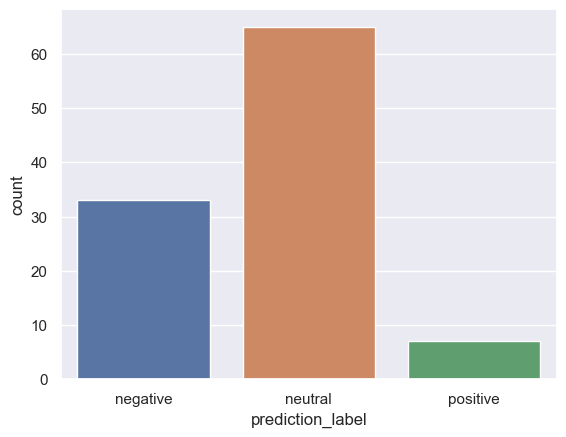

In [33]:
sns.set(style="darkgrid")
ax = sns.countplot(x="prediction_label", data=data)